# Optical Wave Gauging for Google Colab

by Daniel Buscombe, daniel.buscombe@nau.edu

This notebook is part of https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN

### Train an optical wave gage (OWG) to estimate wave height from an image


First, enable a GPU runtime: 

In Colab, go to runtime > change runtime type > hardware accelerator: GPU


Workflow:

1. Write a configuration file - this is how you interact with OWG functions
2. Download the data and model weights
3. Define the model
4. Generate test images and associated wave heights from the downloaded imagery
5. Use the model to estimate wave height for each image
6. Make plots

Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import os, gc, requests, zipfile
import time, datetime, json
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

This notebook assumes you are in Google Colab. Therefore, switch to Tensorflow 2 and verify by printing the version, which should say '2.X.X' where X can be any number

In [3]:
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import mean_absolute_error

2.5.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Write the configuration file using the magic command 'writefile'

In [5]:
%%writefile config_trainMC17trial5.json
{
  "samplewise_std_normalization" : true,
  "samplewise_center"  : true,
  "input_image_format" : "jpg",
  "input_csv_file"     : "C:/njc/src/SSF/OWG/OWG_records/Trial3/mcyv22017trial3train.csv", 
  "category"           : "H",
  "prc_lower_withheld": 0,
  "prc_upper_withheld": 0,
  
  "horizontal_flip"    : false,
  "vertical_flip"      : false,
  "rotation_range"     : 10,
  "width_shift_range"  : 0.1,
  "height_shift_range" : 0.1,
  "shear_range"        : 0.05,
  "zoom_range"         : 0.2,
  "fill_mode"          : "reflect",
  
  "img_size"           : 512,
  "num_epochs"         : 200,
  "test_size"          : 0.5,
  "dropout_rate"       : 0.5,
  "epsilon"            : 0.0001,
  "min_lr"             : 0.0001,
  "factor"             : 0.8
}

Writing config_trainMC17trial5.json


Open the config file and read values into workspace. This might seem like a long-winded way of doing things -- and it is --- but this is how things are set up in the command line python scripts version of this workflow in `https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN/train_OWG.py` so it is maintained here for consistency

In [6]:
with open('config_trainMC17trial5.json') as f:    
    config = json.load(f)

# config variables
imsize    = int(config["img_size"])
num_epochs = int(config["num_epochs"]) 
test_size = float(config["test_size"])
height_shift_range = float(config["height_shift_range"])
width_shift_range = float(config["width_shift_range"])
rotation_range = float(config["rotation_range"])
samplewise_std_normalization = config["samplewise_std_normalization"]
horizontal_flip = config["horizontal_flip"]
vertical_flip = config["vertical_flip"]
samplewise_center = config["samplewise_center"]
shear_range = float(config["shear_range"])
zoom_range = float(config["zoom_range"])
dropout_rate = float(config["dropout_rate"])
epsilon = float(config["epsilon"])
min_lr = float(config["min_lr"])
factor = float(config["factor"])
input_image_format = config["input_image_format"]
input_csv_file = config["input_csv_file"]
category = config["category"] 
fill_mode = config["fill_mode"]
prc_lower_withheld = config['prc_lower_withheld'] 
prc_upper_withheld = config['prc_upper_withheld']
IMG_SIZE = (imsize, imsize) 

In [7]:
image_dir = "C:/njc/src/mcyimgs/2017_imgprep3/view2"

In [8]:
def get_and_tidy_df(base_dir, input_csv_file, image_dir, category):
        df = pd.read_csv(os.path.join(base_dir, input_csv_file))
        df['path'] = df['id'].map(lambda x: os.path.join(base_dir,image_dir,'{}'.format(x)))
            
        df = df.rename(index=str, columns={" H": "H", " T": "T"})   
        
        if category == 'H':
            mean = df['H'].mean() 
            div = df['H'].std() 
            df['zscore'] = df['H'].map(lambda x: (x-mean)/div)
        elif category == 'T':
            mean = df['T'].mean() 
            div = df['T'].std() 
            df['zscore'] = df['T'].map(lambda x: (x-mean)/div)			
        else:
            print("Unknown category: "+str(category))
            print("Fix config file, exiting now ...")
            sys.exit()
        
        df.dropna(inplace = True)
        try:
            df = df.sort_values(by='time', axis=0)
        except:
            df = df.sort_values(by='id', axis=0)

        if category == 'H':
            df['category'] = pd.cut(df['H'], 10)
        else:
            df['category'] = pd.cut(df['T'], 8)
            
        df['index1'] = df.index; new_df = df.groupby(['category']).apply(lambda x: x.sample(int(len(df)/2), replace = True)).reset_index(drop = True)

        return new_df, df  

Get a dataframe to generate test and train data from

In [9]:
# call the utils.py function get_and_tidy_df            	
new_df, df = get_and_tidy_df(os.getcwd(), input_csv_file, image_dir, category)

Get train and test splits and define the generator function that will do the image augmentation

In [10]:
print('New Data Size:', new_df.shape[0], 'Old Size:', df.shape[0])
      
train_df, valid_df = train_test_split(new_df, 
                    test_size = test_size, 
                    random_state = 2018,
                    stratify = new_df['category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

im_gen = ImageDataGenerator(samplewise_center=samplewise_center,
                samplewise_std_normalization=samplewise_std_normalization,
                horizontal_flip = horizontal_flip,  
                vertical_flip = vertical_flip, 
                height_shift_range = height_shift_range, 
                width_shift_range = width_shift_range, 
                rotation_range = rotation_range,
                shear_range = shear_range, 
                fill_mode = fill_mode,
                zoom_range= zoom_range) 

New Data Size: 1770 Old Size: 355
train 885 validation 885


Make a generator from a dataframe	

In [11]:
def gen_from_def(IMG_SIZE, df, image_dir, category, im_gen):

	gen = im_gen.flow_from_dataframe(dataframe=df,
								  directory=image_dir,
								  x_col="path",
								  y_col=category,
								  target_size=IMG_SIZE,
								  batch_size=len(df),
								  color_mode = 'grayscale',
								  shuffle=False,
								  class_mode='raw')
								  	
	ex_X, ex_Y = next(gen)
	return ex_X, ex_Y

Get the train and test images and associated wave heights. This takes a while 

In [12]:
train_X, train_Y = gen_from_def(IMG_SIZE, train_df, image_dir, category, im_gen)
test_X, test_Y = gen_from_def(IMG_SIZE, valid_df, image_dir, category, im_gen)

Found 885 validated image filenames.
Found 885 validated image filenames.


In [13]:
batch_size = 13

weights_path='mcy_H_weights_trial5_'+str(batch_size)+'batch.best.nearshore.hdf5'	
      
print(weights_path)

mcy_H_weights_trial5_13batch.best.nearshore.hdf5


Create a model checkpoint, and training utilities such as early stopping, and reduce learning rate on a plateau in validaion loss

In [14]:
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, verbose=1, mode='auto', epsilon=epsilon, cooldown=5, min_lr=min_lr)
earlystop = EarlyStopping(monitor="val_loss", mode="min", patience=25) 
callbacks_list = [model_checkpoint, earlystop, reduceloss_plat]	

In [16]:
# mean absolute error
def mae_metric(in_gt, in_pred):
    return mean_absolute_error(in_gt, in_pred)

Set model and print a summary

In [17]:
base_model = MobileNet(input_shape =  (IMG_SIZE[0], IMG_SIZE[1],1), include_top = False, weights = None)			
OWG = Sequential()
OWG.add(BatchNormalization(input_shape = (IMG_SIZE[0], IMG_SIZE[1],1)))
OWG.add(base_model)
OWG.add(BatchNormalization())
OWG.add(GlobalAveragePooling2D())
OWG.add(Dropout(0.5)) 
OWG.add(Dense(1, activation = 'linear' )) 

OWG.compile(optimizer = 'rmsprop', loss = 'mse', metrics = [mae_metric])
OWG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 512, 512, 1)       4         
_________________________________________________________________
mobilenet_1.00_512 (Function (None, 16, 16, 1024)      3228288   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_______________________________________

In [18]:
%%time
history = OWG.fit(train_X, train_Y, batch_size=batch_size, 
                  validation_data = (test_X, test_Y),
                  epochs=num_epochs, callbacks = callbacks_list)

OWG.load_weights(weights_path)

Epoch 1/200
69/69 [==============================] - 41s 445ms/step - loss: 1.8194 - mae_metric: 0.8354 - val_loss: 0.6328 - val_mae_metric: 0.6715

Epoch 00001: val_loss improved from inf to 0.63281, saving model to mcy_H_weights_trial5_13batch.best.nearshore.hdf5
Epoch 2/200
69/69 [==============================] - 30s 430ms/step - loss: 0.4665 - mae_metric: 0.5298 - val_loss: 0.9323 - val_mae_metric: 0.7849

Epoch 00002: val_loss did not improve from 0.63281
Epoch 3/200
69/69 [==============================] - 30s 432ms/step - loss: 0.3633 - mae_metric: 0.4747 - val_loss: 2.8544 - val_mae_metric: 1.5163

Epoch 00003: val_loss did not improve from 0.63281
Epoch 4/200
69/69 [==============================] - 30s 432ms/step - loss: 0.2826 - mae_metric: 0.4278 - val_loss: 4.5406 - val_mae_metric: 1.9963

Epoch 00004: val_loss did not improve from 0.63281
Epoch 5/200
69/69 [==============================] - 30s 435ms/step - loss: 0.2628 - mae_metric: 0.4062 - val_loss: 1.9773 - val_mae_m

69/69 [==============================] - 30s 440ms/step - loss: 0.0571 - mae_metric: 0.1898 - val_loss: 0.1109 - val_mae_metric: 0.2545

Epoch 00038: val_loss did not improve from 0.07879
Epoch 39/200
69/69 [==============================] - 30s 442ms/step - loss: 0.0548 - mae_metric: 0.1870 - val_loss: 0.1331 - val_mae_metric: 0.2930

Epoch 00039: val_loss did not improve from 0.07879
Epoch 40/200
69/69 [==============================] - 30s 443ms/step - loss: 0.0695 - mae_metric: 0.2080 - val_loss: 0.1183 - val_mae_metric: 0.2852

Epoch 00040: val_loss did not improve from 0.07879
Epoch 41/200
69/69 [==============================] - 30s 441ms/step - loss: 0.0556 - mae_metric: 0.1911 - val_loss: 0.0820 - val_mae_metric: 0.2275

Epoch 00041: val_loss did not improve from 0.07879
Epoch 42/200
69/69 [==============================] - 31s 444ms/step - loss: 0.0690 - mae_metric: 0.2053 - val_loss: 0.0698 - val_mae_metric: 0.2043

Epoch 00042: val_loss improved from 0.07879 to 0.06985, sav

69/69 [==============================] - 31s 443ms/step - loss: 0.0526 - mae_metric: 0.1831 - val_loss: 0.0601 - val_mae_metric: 0.1832

Epoch 00076: val_loss did not improve from 0.05893
Epoch 77/200
69/69 [==============================] - 31s 444ms/step - loss: 0.0589 - mae_metric: 0.1915 - val_loss: 0.0581 - val_mae_metric: 0.1777

Epoch 00077: val_loss improved from 0.05893 to 0.05813, saving model to mcy_H_weights_trial5_13batch.best.nearshore.hdf5
Epoch 78/200
69/69 [==============================] - 31s 445ms/step - loss: 0.0498 - mae_metric: 0.1774 - val_loss: 0.0579 - val_mae_metric: 0.1837

Epoch 00078: val_loss improved from 0.05813 to 0.05792, saving model to mcy_H_weights_trial5_13batch.best.nearshore.hdf5
Epoch 79/200
69/69 [==============================] - 31s 445ms/step - loss: 0.0466 - mae_metric: 0.1703 - val_loss: 0.0713 - val_mae_metric: 0.2171

Epoch 00079: val_loss did not improve from 0.05792
Epoch 80/200
69/69 [==============================] - 31s 445ms/step 

69/69 [==============================] - 31s 450ms/step - loss: 0.0444 - mae_metric: 0.1680 - val_loss: 0.0562 - val_mae_metric: 0.1755

Epoch 00114: val_loss did not improve from 0.05583
Epoch 115/200
69/69 [==============================] - 31s 448ms/step - loss: 0.0584 - mae_metric: 0.1895 - val_loss: 0.0569 - val_mae_metric: 0.1801

Epoch 00115: val_loss did not improve from 0.05583
Epoch 116/200
69/69 [==============================] - 31s 451ms/step - loss: 0.0461 - mae_metric: 0.1617 - val_loss: 0.0553 - val_mae_metric: 0.1738

Epoch 00116: val_loss improved from 0.05583 to 0.05533, saving model to mcy_H_weights_trial5_13batch.best.nearshore.hdf5
Epoch 117/200
69/69 [==============================] - 31s 447ms/step - loss: 0.0457 - mae_metric: 0.1672 - val_loss: 0.0647 - val_mae_metric: 0.1857

Epoch 00117: val_loss did not improve from 0.05533
Epoch 118/200
69/69 [==============================] - 31s 452ms/step - loss: 0.0359 - mae_metric: 0.1414 - val_loss: 0.0564 - val_mae_m

Make a plot showing training history

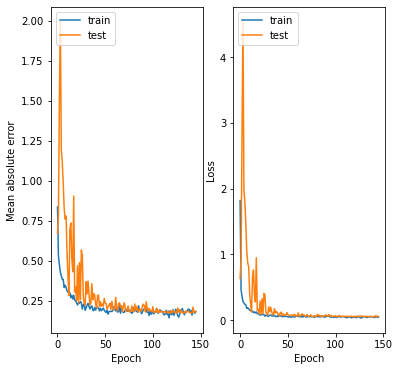

In [19]:
fig = plt.figure(figsize = (6,6))
plt.subplot(121)
# summarize history for accuracy
plt.plot(history.history['mae_metric'])
plt.plot(history.history['val_mae_metric'])
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

Make a plot showing predicted wave heights versus observed

Use the model to estimate wave height from every image (that number can be anything from 1 to the length of `test_X`)

In [20]:
pred_Y = np.squeeze(OWG.predict(test_X, batch_size = batch_size, verbose = True))

69/69 [==============================] - 4s 52ms/step


Make a plot of observed versus estimated wave height

[INFO] Plotting ...


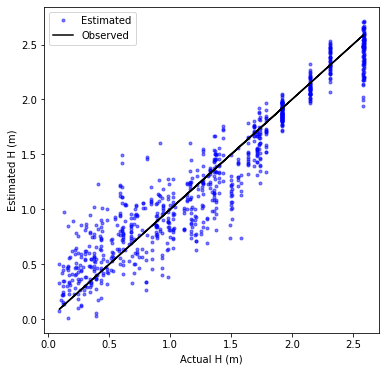

In [21]:
print ("[INFO] Plotting ...")     												        
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y, pred_Y, 'b.', alpha=0.5, label = 'Estimated')
ax1.plot(test_Y, test_Y, 'k-', label = 'Observed')
ax1.legend()
if category=='H':
   ax1.set_xlabel('Actual H (m)')
   ax1.set_ylabel('Estimated H (m)')
else:
   ax1.set_xlabel('Actual T (s)')
   ax1.set_ylabel('Estimated T (s)')    
plt.show() 

Show a few augmanted test images and their estimates wave height (and observed wave height, for comparison) 

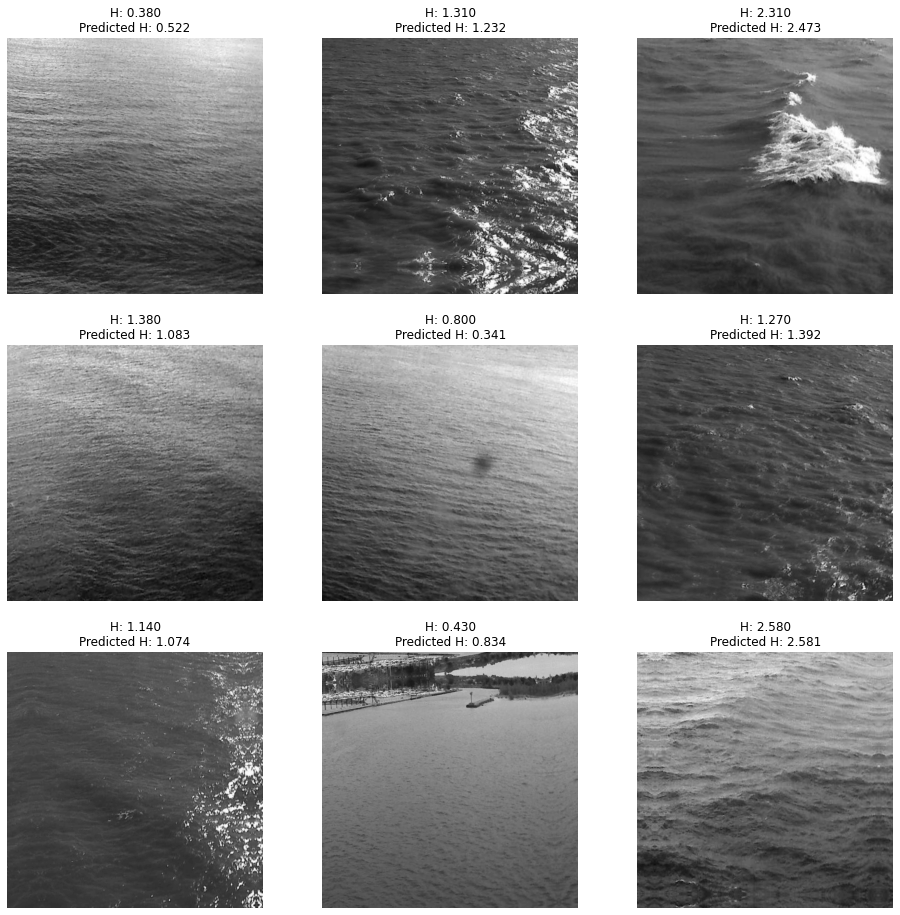

In [22]:
rand_idx = np.random.choice(range(test_X.shape[0]), 9)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (idx, c_ax) in zip(rand_idx, m_axs.flatten()):
  c_ax.imshow(test_X[idx, :,:,0], cmap = 'gray')
  if category == 'H':
      c_ax.set_title('H: %0.3f\nPredicted H: %0.3f' % (test_Y[idx], pred_Y[idx]))
  else:
      c_ax.set_title('T: %0.3f\nPredicted T: %0.3f' % (test_Y[idx], pred_Y[idx]))
  
  c_ax.axis('off')

In [23]:
#r^2 value

from scipy.stats import linregress

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

In [24]:
r_value = rsquared(test_Y, pred_Y)
# round r^2 to the number of decimal places that is present in the OWG_train mean absolute error
print (round(r_value, 5))

0.90286


In [25]:
def mape(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [26]:
errorper = mape(test_Y, pred_Y)
print (errorper)

27.859529260441214
